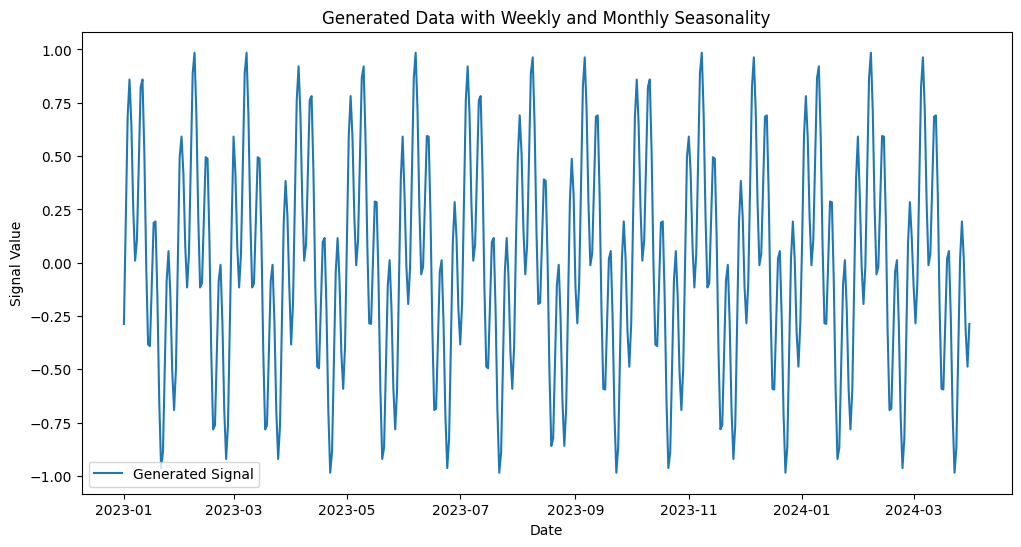

Epoch 1/50
7/7 [==============================] - 3s 108ms/step - loss: 0.2916 - val_loss: 0.2779
Epoch 2/50
7/7 [==============================] - 0s 58ms/step - loss: 0.2332 - val_loss: 0.2150
Epoch 3/50
7/7 [==============================] - 0s 70ms/step - loss: 0.1660 - val_loss: 0.1211
Epoch 4/50
7/7 [==============================] - 1s 71ms/step - loss: 0.0971 - val_loss: 0.0875
Epoch 5/50
7/7 [==============================] - 1s 90ms/step - loss: 0.0802 - val_loss: 0.0721
Epoch 6/50
7/7 [==============================] - 1s 82ms/step - loss: 0.0684 - val_loss: 0.0626
Epoch 7/50
7/7 [==============================] - 1s 78ms/step - loss: 0.0644 - val_loss: 0.0634
Epoch 8/50
7/7 [==============================] - 0s 73ms/step - loss: 0.0618 - val_loss: 0.0586
Epoch 9/50
7/7 [==============================] - 0s 67ms/step - loss: 0.0611 - val_loss: 0.0597
Epoch 10/50
7/7 [==============================] - 1s 77ms/step - loss: 0.0590 - val_loss: 0.0558
Epoch 11/50
7/7 [===========

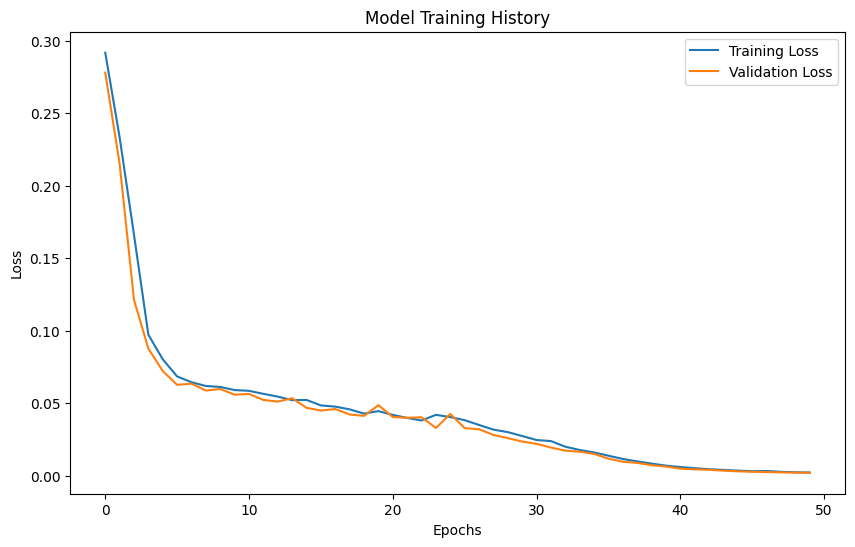

3/3 [==============================] - 0s 21ms/step


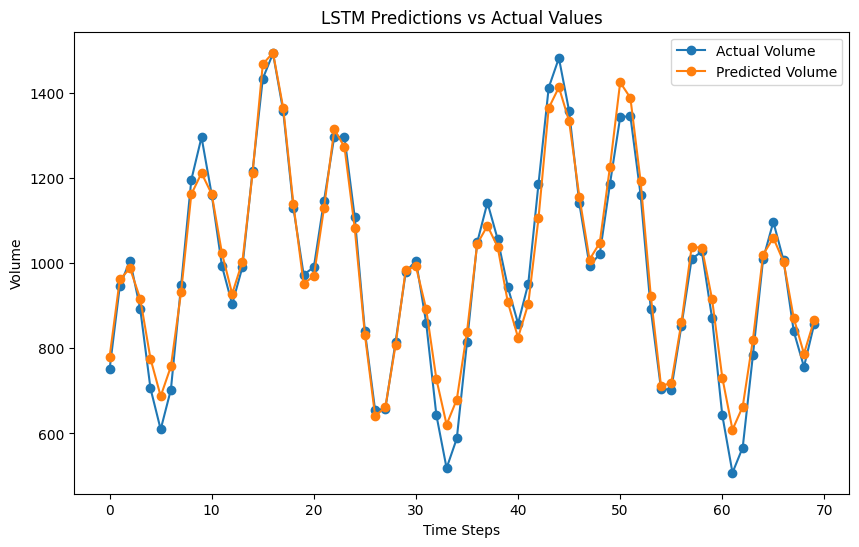

Mean Absolute Error (MAE): 33.08491645671877


In [166]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Generating sample data
np.random.seed(42)

date_range = pd.date_range(start='2023-01-01', end='2024-03-31', freq='D')
df = pd.DataFrame(index=date_range)

weekly_seasonality = np.sin(2 * np.pi * df.index.weekday / 7)
df['weekly_seasonality'] = weekly_seasonality

monthly_seasonality = np.sin(2 * np.pi * df.index.day / 30)
df['monthly_seasonality'] = monthly_seasonality

df['combined_seasonality'] = 0.5 * weekly_seasonality + 0.5 * monthly_seasonality

noise = np.random.normal(loc=0, scale=0.2, size=len(df))
df['noise'] = 0

df['signal'] = df['combined_seasonality'] + df['noise']

plt.figure(figsize=(12, 6))
plt.plot(df['signal'], label='Generated Signal')
plt.title('Generated Data with Weekly and Monthly Seasonality')
plt.xlabel('Date')
plt.ylabel('Signal Value')
plt.legend()
plt.show()

df['isMon'] = (df.index.dayofweek == 0).astype(int)
df['isTue'] = (df.index.dayofweek == 1).astype(int)
df['isWed'] = (df.index.dayofweek == 2).astype(int)
df['isThu'] = (df.index.dayofweek == 3).astype(int)
df['isFri'] = (df.index.dayofweek == 4).astype(int)
df['isSat'] = (df.index.dayofweek == 5).astype(int)
df['isSun'] = (df.index.dayofweek == 6).astype(int)
df['Volume'] = 1000 + (500 * df['signal'])

df = df.drop(['weekly_seasonality', 'monthly_seasonality', 'weekly_seasonality', 'combined_seasonality', 'signal', 'noise'], axis=1)

def prepare_data(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix, :].values.flatten()
        seq_y = data.iloc[end_ix:out_end_ix, -1].values
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

n_steps_in = 100
n_steps_out = 7

X, y = prepare_data(pd.DataFrame(scaled_data), n_steps_in, n_steps_out)

split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train = X_train.reshape(X_train.shape[0], n_steps_in, -1)
X_test = X_test.reshape(X_test.shape[0], n_steps_in, -1)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, X_train.shape[2])))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(patience=5)])

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Invert scaling for actual values
y_test_inv = y_test * (scaler.data_max_[-1] - scaler.data_min_[-1]) + scaler.data_min_[-1]

# Invert scaling for predicted values
y_pred_inv = y_pred * (scaler.data_max_[-1] - scaler.data_min_[-1]) + scaler.data_min_[-1]

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv[:, -1], label='Actual Volume', marker='o')
plt.plot(y_pred_inv[:, -1], label='Predicted Volume', marker='o')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inv[:, -1], y_pred_inv[:, -1])
print(f'Mean Absolute Error (MAE): {mae}')


In [167]:
df# X_test = X_test.reshape(X_test.shape[0], n_steps_in, -1)

,isMon,isTue,isWed,isThu,isFri,isSat,isSun,Volume
2023-01-01,0,0,0,0,0,0,1,856.520052
2023-01-02,1,0,0,0,0,0,0,1101.684161
2023-01-03,0,1,0,0,0,0,0,1342.404184
2023-01-04,0,0,1,0,0,0,0,1429.518184
2023-01-05,0,0,0,1,0,0,0,1324.977286
...,...,...,...,...,...,...,...,...
2024-03-27,0,0,1,0,0,0,0,1096.785665
2024-03-28,0,0,0,1,0,0,0,1006.786774
2024-03-29,0,0,0,0,1,0,0,839.551143
2024-03-30,0,0,0,0,0,1,0,756.268022


In [168]:
# ... (your existing code)

# Specify the date range for prediction
prediction_start_date = '2024-04-01'
prediction_end_date = '2024-06-12'
prediction_date_range = pd.date_range(start=prediction_start_date, end=prediction_end_date, freq='D')

# Generate a DataFrame for the prediction date range with features (isMon, isTue, ...)
prediction_df = pd.DataFrame(index=prediction_date_range)
prediction_df['isMon'] = (prediction_df.index.dayofweek == 0).astype(int)
prediction_df['isTue'] = (prediction_df.index.dayofweek == 1).astype(int)
prediction_df['isWed'] = (prediction_df.index.dayofweek == 2).astype(int)
prediction_df['isThu'] = (prediction_df.index.dayofweek == 3).astype(int)
prediction_df['isFri'] = (prediction_df.index.dayofweek == 4).astype(int)
prediction_df['isSat'] = (prediction_df.index.dayofweek == 5).astype(int)
prediction_df['isSun'] = (prediction_df.index.dayofweek == 6).astype(int)
prediction_df['Volume'] = np.nan


In [169]:
old_new_combo_df = pd.concat([df,prediction_df])
old_new_combo_df['Volume_backup']=old_new_combo_df['Volume']


In [170]:
old_new_combo_df=old_new_combo_df.reset_index()
old_new_combo_df

,index,isMon,isTue,isWed,isThu,isFri,isSat,isSun,Volume,Volume_backup
0,2023-01-01,0,0,0,0,0,0,1,856.520052,856.520052
1,2023-01-02,1,0,0,0,0,0,0,1101.684161,1101.684161
2,2023-01-03,0,1,0,0,0,0,0,1342.404184,1342.404184
3,2023-01-04,0,0,1,0,0,0,0,1429.518184,1429.518184
4,2023-01-05,0,0,0,1,0,0,0,1324.977286,1324.977286
...,...,...,...,...,...,...,...,...,...,...
524,2024-06-08,0,0,0,0,0,1,0,NaN,NaN
525,2024-06-09,0,0,0,0,0,0,1,NaN,NaN
526,2024-06-10,1,0,0,0,0,0,0,NaN,NaN
527,2024-06-11,0,1,0,0,0,0,0,NaN,NaN


In [171]:
# for i in range(len(old_new_combo_df)):
#     if np.isnan(old_new_combo_df.loc[i,'Volume']):
#         if i ==456:
#             print(i)
#             scaled_data = scaler.transform(old_new_combo_df.iloc[i-n_steps_in:i,:].drop(['Volume_backup','index'],axis=1))
#             X_future, y_future = prepare_data(pd.DataFrame(scaled_data), n_steps_in, n_steps_out)
        

In [172]:
# prepare_data(pd.DataFrame(scaled_data), n_steps_in, n_steps_out)

In [173]:
predicted_volume_inv

array([[ 954.3104 , 1031.8917 ,  997.7095 ,  951.1392 ,  881.4407 ,
         799.30334,  808.2941 ]], dtype=float32)

1/1 [==============================] - 0s 84ms/step


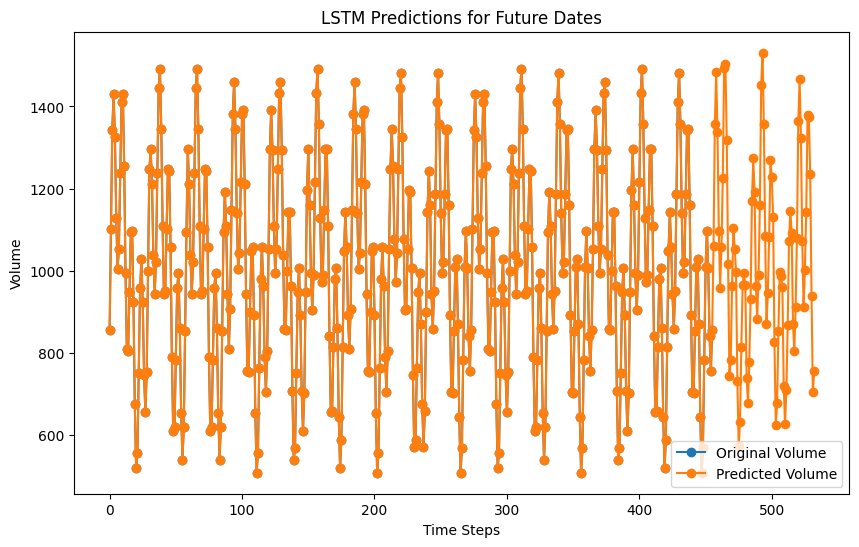

In [174]:
for i in range(len(old_new_combo_df)):
    if np.isnan(old_new_combo_df.loc[i, 'Volume']):
        # Prepare data for prediction
        scaled_data_temp = scaler.transform(old_new_combo_df.iloc[i - n_steps_in:i, :].drop(['Volume_backup', 'index'], axis=1))
        seq_x = scaled_data_temp.flatten().reshape(1, n_steps_in, -1)

        # Make predictions using the trained model
        predicted_volume = model.predict(seq_x)

        # Invert scaling for predicted values
        predicted_volume_inv = predicted_volume * (scaler.data_max_[-1] - scaler.data_min_[-1]) + scaler.data_min_[-1]

        # Update the 'Volume' column in old_new_combo_df with the predicted values
        for j in range(n_steps_out):
            old_new_combo_df.loc[i + j, 'Volume'] = predicted_volume_inv[0, j]

# Plot the original and predicted values
plt.figure(figsize=(10, 6))
plt.plot(old_new_combo_df['Volume_backup'], label='Original Volume', marker='o')
plt.plot(old_new_combo_df['Volume'], label='Predicted Volume', marker='o')
plt.title('LSTM Predictions for Future Dates')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()
